In [ ]:
User
import csv
import time
from pylsl import StreamInlet, resolve_byprop
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import math
import sys

# CSVファイルにデータを保存する関数
def save_data_to_csv(start_time, timestamp, data, filename):
    fieldnames = ['timestamp', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    with open(filename, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # ヘッダーがない場合は、ヘッダーを書き込む
        csvfile.seek(0, 2)
        if csvfile.tell() == 0:
            writer.writeheader()

        # Start time subtraction for relative timestamps
        relative_timestamp = lsl_to_local_datetime(timestamp) - start_time
        row = {'timestamp': relative_timestamp.total_seconds()}
        row.update({fieldnames[i + 1]: data[i+3] for i in range(len(data)-5)})
        writer.writerow(row)
        
# マーカー付きデータをｃｓｖ保存
def save_data_to_csv_with_marker(start_time, timestamp, sample, marker, filename):
    # 開始と終了の3つの要素を削除し、タイムスタンプを0から始まるように修正
    sample = sample[3:-2]
    timestamp -= start_time
    
    # DataFrameを作成し、データを追記していく
    # sampleはリスト形式でデータが渡される
    # マーカーもこのDataFrameに格納
    # タイムスタンプを先頭に追加
    df = pd.DataFrame([[timestamp] + sample + [marker]])  

    with open(filename, 'a') as f:
        df.to_csv(f, header=f.tell() == 0, index=False, lineterminator='\n')  # headerはファイルの先頭だけに出力


#CSVファイルからデータを読み込む関数
def load_data_from_csv(filename):
    data = []
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data.append(row)

    return data

# データをプロットする関数
def plot_data(data, channels):
    timestamps = [float(row['timestamp']) for row in data]

    plt.figure(figsize=(15, 8))

    for channel in channels:
        values = [float(row[channel]) for row in data]
        plt.plot(timestamps, values, label=channel)

    plt.xlabel('Timestamp (s)')
    plt.ylabel('Sensor Value')
    plt.title('Brainwave Data')
    plt.legend()
    plt.show()
    
def plot_data_for_parallel(data, channels, title, subplot_position):
    plt.subplot(1, 2, subplot_position)
    time = np.arange(len(data)) / 256.0  # Create a time array (assuming data was collected at 256 Hz)

    for channel in channels:
        plt.plot(time, data[channel], label=channel)

    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    
    
#データをプロットする関数
def plot_data_with_marker(data, channels):
    timestamps = [float(row['Timestamp']) for row in data]

    plt.figure(figsize=(15, 8))

    for channel in channels:
        values = [float(row[channel]) for row in data]
        plt.plot(timestamps, values, label=channel)

    # Remove duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel('Timestamp (s)')
    plt.ylabel('Sensor Value')
    plt.title('Brainwave Data')
    plt.show()

    
def lsl_to_local_datetime(lsl_timestamp):
    return datetime.fromtimestamp(lsl_timestamp)


# 256Hzで収集（デフォルト）
def collect_EEG(filename, duration):
    # EPOCXのストリームを探す
    streams = resolve_byprop('type', 'EEG', timeout=5)

    if not streams:
        raise RuntimeError("No EEG stream found. Make sure the EmotivPro LSL Connector is running.")

    # ストリームを開く
    inlet = StreamInlet(streams[0])

    print("Connected to Emotiv EPOCX stream.")

    # ファイルを上書きモードで開く
    with open(filename, 'w') as f:
        # チャンネル名のラベルを設定
        header = ['Timestamp'] + ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'] + ['Marker']
        f.write(','.join(header) + '\n')

    # データを取得し、CSVファイルに記録する
    start_time = None

    #収集開始
    def collect_data():
        nonlocal start_time, marker_set
        while True:
            sample, timestamp = inlet.pull_sample()
            if start_time is None:
                start_time = timestamp
            elapsed_time = timestamp - start_time
            
            save_data_to_csv_with_marker(start_time, timestamp, sample, filename)  

            if elapsed_time >= duration:
                break

    print("done.")
    return

In [1]:
fieldnames = ['timestamp', "Cz", "Fz", "Fp1", "F7", "F3", "FC1", "C3", "FC5", "FT9", "T7", "CP5", "CP1", "P3", "P7", "PO9", "O1", "Pz", "Oz", "O2", "PO10", "P8", "P4", "CP2",  "CP6", "T8", "FT10", "FC6", "C4", "FC2", "F4", "F8", "Fp2"]

# EPOC FLEXのストリームを探す
streams = resolve_byprop('type', 'EEG', timeout=5)

if not streams:
    raise RuntimeError("No EEG stream found. Make sure the EmotivPro LSL Connector is running.")

# ストリームを開く
inlet = StreamInlet(streams[0])

print("Connected to Emotiv EPOC FLEX stream.")

# CSVファイル名を指定
filename = 'epoc_FLEX_data.csv'

# ファイルを上書きモードで開いてすぐ閉じることで、中身を空にする
with open(filename, 'w') as f:
    pass

# データを取得し、CSVファイルに記録する
duration = 10  # 収集するデータの期間（秒）
start_time = time.time()

while time.time() - start_time < duration:
    sample, timestamp = inlet.pull_sample()
    save_data_to_csv(timestamp, sample, filename, fieldnames)
    time.sleep(1/128.0)  # 128Hzでデータを取得する


Connected to Emotiv EPOC FLEX stream.


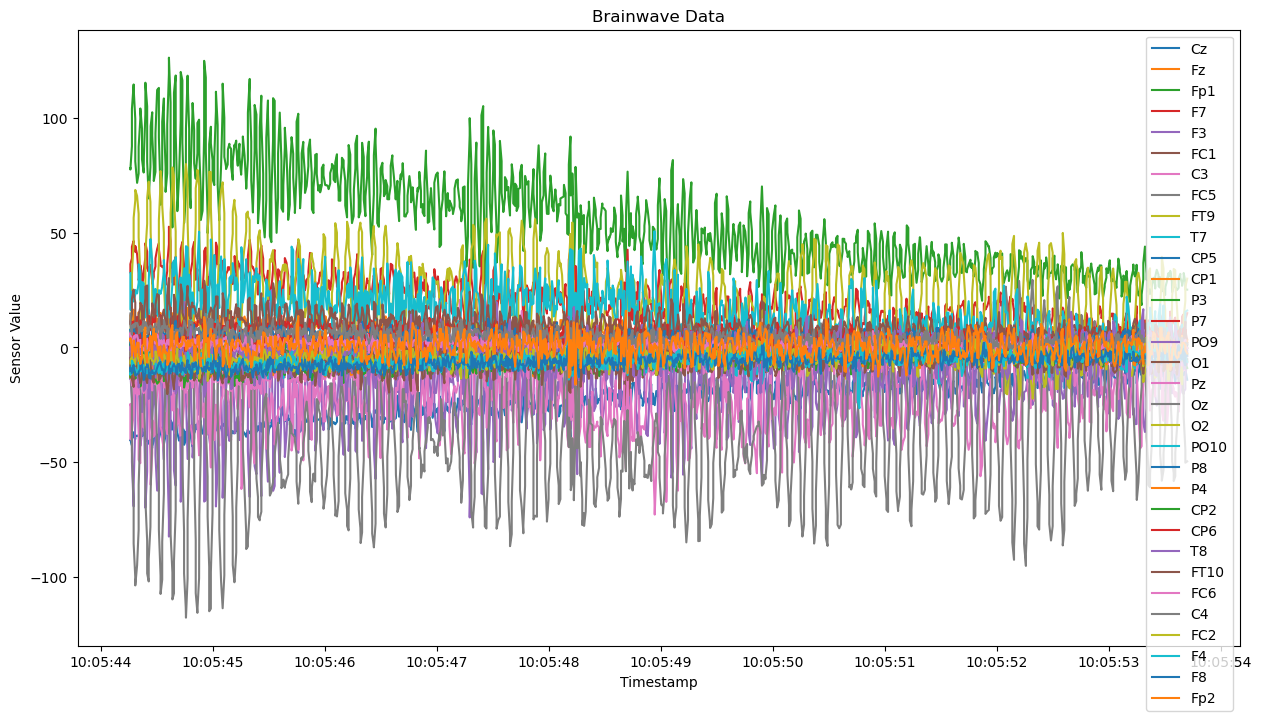

In [2]:
# 実行
if __name__ == "__main__":
    filename = 'epoc_FLEX_data.csv'
    data = load_data_from_csv(filename)

    # 選択したチャンネルをプロット
    channels = ["Cz", "Fz", "Fp1", "F7", "F3", "FC1", "C3", "FC5", "FT9", "T7", "CP5", "CP1", "P3", "P7", "PO9", "O1", "Pz", "Oz", "O2", "PO10", "P8", "P4", "CP2",  "CP6", "T8", "FT10", "FC6", "C4", "FC2", "F4", "F8", "Fp2"]
    plot_data(data, channels)